In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

In [2]:
print(tf.__version__)

2.8.0


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.keras.backend.clear_session()

In [5]:
# Load the dataset from tensorflow datasets
(training_data, testing_data), metadata = tfds.load(name="mnist",
                                                    shuffle_files=False, 
                                                    as_supervised=True, 
                                                    with_info=True,
                                                    split=["train", "test"])

In [6]:
num_examples = metadata.splits["train"].num_examples
num_examples

60000

In [7]:
split_size = int(0.8 * num_examples)
train_data = training_data.take(split_size)
val_data = training_data.skip(split_size)

In [8]:
len(train_data), len(val_data), len(testing_data)

(48000, 12000, 10000)

In [9]:
train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []

In [10]:
for data in train_data:
    image, label = data
    train_images.append(image)
    train_labels.append(label)

for data in val_data:
    image, label = data
    val_images.append(image)
    val_labels.append(label)

for data in testing_data:
    image, label = data
    test_images.append(image)
    test_labels.append(label)

In [11]:
len(train_images), len(train_labels), len(val_images), len(val_labels), len(test_images), len(test_labels)

(48000, 48000, 12000, 12000, 10000, 10000)

In [12]:
train_images = tf.constant(np.array(train_images))
train_images

<tf.Tensor: shape=(48000, 28, 28, 1), dtype=uint8, numpy=
array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0]

In [13]:
train_labels = tf.constant(np.array(train_labels))
val_images = tf.constant(np.array(val_images))
val_labels = tf.constant(np.array(val_labels))
test_images = tf.constant(np.array(test_images))
test_labels = tf.constant(np.array(test_labels))

In [14]:
class_names = metadata.features['label'].names
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [15]:
import random
def view_random_dataset_images(images, labels):
    random_num = random.randint(0, len(images)-1)
    random_img = images[random_num]
    random_label = labels[random_num]
    random_class = class_names[random_label]
    plt.figure(figsize=(10, 7))
    plt.imshow(random_img)
    plt.title(f"Class name: {random_class}")
    plt.axis(False)

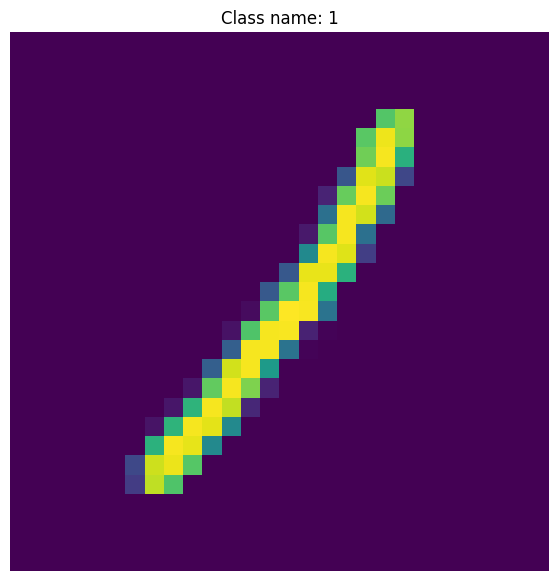

In [16]:
view_random_dataset_images(train_images, train_labels)

In [17]:
train_images[0].shape

TensorShape([28, 28, 1])

In [18]:
def preprocess_image(images):
    return tf.cast(images, dtype=tf.float32) / 255.

In [19]:
train_images = preprocess_image(train_images)
val_images = preprocess_image(val_images)
test_images = preprocess_image(test_images)

In [ ]:
# Callbacks
import datetime
import os

CHECKPOINT_PATH = "model_experiments_mnist_clf"
LOG_PATH = "model_logs_mnist_clf"

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, min_lr=1e-6, factor=0.1, verbose=1)

def tensorboard(model_name):
    log_dir = os.path.join(LOG_PATH, model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(log_dir)

def checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(filepath= os.path.join(CHECKPOINT_PATH, model_name) , monitor="val_loss", save_best_only=True, verbose=1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10 ** (epoch/20), verbose=1)

In [21]:
model_1 = tf.keras.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Flatten(),
    layers.Dense(120, activation="relu"),
    layers.Dense(120, activation="relu"),
    layers.Dense(len(class_names), activation="softmax")
], name="model_1_mnist_clf")

model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [22]:
model_1_history = model_1.fit(train_images,
                              train_labels,
                              epochs=15,
                              validation_data=(val_images, val_labels),
                              batch_size=64,
                              validation_batch_size=64,
                              shuffle=True,
                              callbacks=[tensorboard(model_1.name),
                                         checkpoint(model_1.name),
                                         early_stopping,
                                         reduce_lr])

Epoch 1/15
748/750 [============================>.] - ETA: 0s - loss: 0.2975 - accuracy: 0.9155
Epoch 1: val_loss improved from inf to 0.16088, saving model to model_experiments\model_1_mnist_clf
INFO:tensorflow:Assets written to: model_experiments\model_1_mnist_clf\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_mnist_clf\assets


750/750 [==============================] - 6s 6ms/step - loss: 0.2975 - accuracy: 0.9155 - val_loss: 0.1609 - val_accuracy: 0.9529 - lr: 0.0010
Epoch 2/15
744/750 [============================>.] - ETA: 0s - loss: 0.1191 - accuracy: 0.9645
Epoch 2: val_loss improved from 0.16088 to 0.11808, saving model to model_experiments\model_1_mnist_clf
INFO:tensorflow:Assets written to: model_experiments\model_1_mnist_clf\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_mnist_clf\assets


750/750 [==============================] - 4s 5ms/step - loss: 0.1188 - accuracy: 0.9645 - val_loss: 0.1181 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 3/15
747/750 [============================>.] - ETA: 0s - loss: 0.0820 - accuracy: 0.9746
Epoch 3: val_loss improved from 0.11808 to 0.10867, saving model to model_experiments\model_1_mnist_clf
INFO:tensorflow:Assets written to: model_experiments\model_1_mnist_clf\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_mnist_clf\assets


750/750 [==============================] - 5s 6ms/step - loss: 0.0820 - accuracy: 0.9746 - val_loss: 0.1087 - val_accuracy: 0.9664 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.9812
Epoch 4: val_loss improved from 0.10867 to 0.09480, saving model to model_experiments\model_1_mnist_clf
INFO:tensorflow:Assets written to: model_experiments\model_1_mnist_clf\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_mnist_clf\assets


750/750 [==============================] - 4s 6ms/step - loss: 0.0605 - accuracy: 0.9812 - val_loss: 0.0948 - val_accuracy: 0.9713 - lr: 0.0010
Epoch 5/15
736/750 [============================>.] - ETA: 0s - loss: 0.0459 - accuracy: 0.9858
Epoch 5: val_loss improved from 0.09480 to 0.08817, saving model to model_experiments\model_1_mnist_clf
INFO:tensorflow:Assets written to: model_experiments\model_1_mnist_clf\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_mnist_clf\assets


750/750 [==============================] - 4s 5ms/step - loss: 0.0463 - accuracy: 0.9857 - val_loss: 0.0882 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 6/15
750/750 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9885
Epoch 6: val_loss did not improve from 0.08817
750/750 [==============================] - 3s 4ms/step - loss: 0.0376 - accuracy: 0.9885 - val_loss: 0.0892 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 7/15
745/750 [============================>.] - ETA: 0s - loss: 0.0307 - accuracy: 0.9904
Epoch 7: val_loss did not improve from 0.08817
750/750 [==============================] - 4s 5ms/step - loss: 0.0307 - accuracy: 0.9904 - val_loss: 0.1023 - val_accuracy: 0.9722 - lr: 0.0010
Epoch 8/15
748/750 [============================>.] - ETA: 0s - loss: 0.0241 - accuracy: 0.9926
Epoch 8: val_loss did not improve from 0.08817

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
750/750 [==============================] - 4s 5ms/step - loss

INFO:tensorflow:Assets written to: model_experiments\model_1_mnist_clf\assets


750/750 [==============================] - 4s 6ms/step - loss: 0.0095 - accuracy: 0.9976 - val_loss: 0.0765 - val_accuracy: 0.9793 - lr: 1.0000e-04
Epoch 10/15
748/750 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9990
Epoch 10: val_loss improved from 0.07645 to 0.07591, saving model to model_experiments\model_1_mnist_clf
INFO:tensorflow:Assets written to: model_experiments\model_1_mnist_clf\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_mnist_clf\assets


750/750 [==============================] - 4s 6ms/step - loss: 0.0059 - accuracy: 0.9990 - val_loss: 0.0759 - val_accuracy: 0.9797 - lr: 1.0000e-04
Epoch 11/15
746/750 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9994
Epoch 11: val_loss did not improve from 0.07591
750/750 [==============================] - 4s 5ms/step - loss: 0.0047 - accuracy: 0.9994 - val_loss: 0.0771 - val_accuracy: 0.9794 - lr: 1.0000e-04
Epoch 12/15
743/750 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.9995
Epoch 12: val_loss did not improve from 0.07591
750/750 [==============================] - 4s 5ms/step - loss: 0.0041 - accuracy: 0.9995 - val_loss: 0.0777 - val_accuracy: 0.9803 - lr: 1.0000e-04
Epoch 13/15
743/750 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9997
Epoch 13: val_loss did not improve from 0.07591

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
750/750 [==============================] -

In [23]:
model_1.evaluate(val_images, val_labels)

375/375 [==============================] - 2s 4ms/step - loss: 0.0759 - accuracy: 0.9797


[0.07590775191783905, 0.9797499775886536]

In [24]:
model_1.evaluate(train_images, train_labels)

1500/1500 [==============================] - 5s 3ms/step - loss: 0.0046 - accuracy: 0.9995


[0.0045860749669373035, 0.9995208382606506]

In [26]:
model_1.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.0758 - accuracy: 0.9804


[0.07582416385412216, 0.980400025844574]

In [27]:
%load_ext tensorboard

In [29]:
%tensorboard --logdir model_logs --port 8086

In [30]:
model_1_loaded = tf.keras.models.load_model(CHECKPOINT_PATH + "/" + model_1.name)

In [31]:
model_1_loaded.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0758 - accuracy: 0.9804


[0.07582416385412216, 0.980400025844574]